## Libraries

In [1]:
# Libraries
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, hour, dayofweek, month, when, udf, year, to_timestamp, avg, stddev, count
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.types import StructType, StructField, FloatType, ArrayType, DoubleType
from pyspark.ml.linalg import DenseVector, SparseVector
import dask.dataframe as dd
from lightgbm.dask import DaskLGBMRegressor
from dask.distributed import Client, LocalCluster
import joblib

Matplotlib created a temporary cache directory at /scratch/zmosley/job_39783397/matplotlib-oroboibe because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
spark = SparkSession.builder \
    .appName("NYC Taxi Full Dataset") \
    .config("spark.executor.instances", "20") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "40g") \
    .config("spark.driver.cores", "4") \
    .config("spark.sql.shuffle.partitions", "300") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .getOrCreate()

## Import Data

In [3]:
# Import 5 years of NYC Yellow Taxi Data
base_path = "/expanse/lustre/projects/uci150/rvasappanavara/shared/nyc_taxi_data/"
file_paths = sorted(glob(f"{base_path}/yellow_tripdata_202[0-4]-*.parquet"))

# Fixes schema compatibility errors
dfs = []
for path in file_paths:
    df = spark.read.parquet(f"file://{path}")
    df = df.withColumn("airport_fee", col("airport_fee").cast("double"))
    dfs.append(df)

raw_df = dfs[0]
for other_df in dfs[1:]:
    raw_df = raw_df.unionByName(other_df)

In [4]:
# Shape of df
num_rows = raw_df.count()
num_cols = len(raw_df.columns)
print(f"Rows: {num_rows}, Columns: {num_cols}")

Rows: 174689444, Columns: 19


In [5]:
raw_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [6]:
summary_df = raw_df.summary()
raw_summary = summary_df.toPandas()
display(raw_summary)

,summary,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,count,174689444,165631891,174689444,165631891,165631891,174689444,174689444,174689444,174689444,174689444,174689444,174689444,174689444,174689444,174689444,165631891,137630064
1,mean,1.728645086305272,1.3935332296604643,5.1446748564266676,1.5601603377214355,None,164.67229989580824,162.84312092721527,1.175978652722714,15.354019532862086,1.2331987166894938,0.4899774909123896,3.9023754576153094,0.49543407625804675,0.6080710715487009,23.804703894103447,2.2665264681425388,0.11753790908649145
2,stddev,0.47453200484085584,0.9545513003212337,486.7041362446293,6.9140250671915435,None,65.19928578808438,70.21261088267867,0.5658858442809493,10639.3136925125,37.869664054595816,37.830169019931056,10638.322148574376,2.0365973061050298,0.3718933443586478,163.94872128117464,0.786779673736705,0.418815352831339
3,min,1,0.0,-30.62,1.0,N,1,1,0,-1.33391414E8,-39.17,-0.55,-493.22,-140.63,-1.0,-2567.8,-2.5,-1.75
4,25%,1,1.0,1.05,1.0,None,132,113,1,7.5,0.0,0.5,0.0,0.0,0.3,13.08,2.5,0.0
5,50%,2,1.0,1.8,1.0,None,162,162,1,11.4,0.5,0.5,2.25,0.0,0.3,17.76,2.5,0.0
6,75%,2,1.0,3.35,1.0,None,234,234,1,18.5,2.5,0.5,3.66,0.0,1.0,26.04,2.5,0.0
7,max,7,112.0,398608.62,99.0,Y,265,265,5,998310.03,500000.8,500000.5,1.3339136353E8,1702.88,2.0,1000003.8,3.0,1.75


# **Preprocessing**

In [7]:
df = raw_df

### fare_amount

In [8]:
# Examining possible outlier fares
print("Zero or negative fares:", df.filter(col("fare_amount") <= 0).count())
print("Fares < $3:", df.filter(col("fare_amount") < 3).count())
print("Fares > $100:", df.filter(col("fare_amount") > 100).count())
print("Fares > $200:", df.filter(col("fare_amount") > 200).count())

Zero or negative fares: 1669498
Fares < $3: 2216730
Fares > $100: 363769
Fares > $200: 43340


#### Standard City Rate, \$3 initial charge
##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245
#### Remove fares below $3, as this is the minimum charge, and exclude outliers with fares above 200 dollars.

In [9]:
# Removing outliers, keeping fares between $3-$200
df = df.filter((col("fare_amount") >= 3) & (col("fare_amount") <= 200))

### Scatterplot of fare distribution

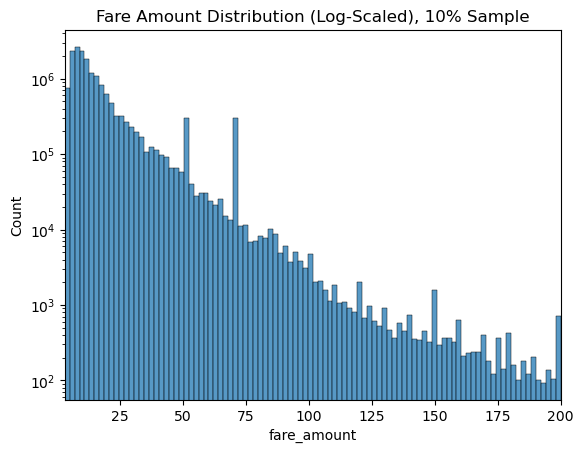

In [10]:
# Using 5% sample of data
scatterplot_sample = df.select("fare_amount").sample(fraction=0.1, seed=2).toPandas()

sns.histplot(scatterplot_sample["fare_amount"], bins=100)
plt.xlim(3, 200)  
plt.yscale("log")  # Log scale  to show more 
plt.title("Fare Amount Distribution (Log-Scaled), 10% Sample")
plt.show()

#### Most of the fare spikes occur at round numbers, with the largest at $70.

#### After some research, its very common to charge flat rates on standard trips like to the airport. Specifically to JFK is $70.

#### "John F. Kennedy Airport (JFK), To or from Manhattan (Rate Code 2), \$70 'Flat Fare.'"
##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

### Toll Amount

#### $20 is the most expensive toll in NYC
##### source: https://pix11.com/news/transit/what-is-the-most-expensive-toll-in-ny/

In [11]:
# Filter for outlier, allow up to $50 to account for multiple tolls on one trip
df = df.filter((df.tolls_amount >= 0) & (df.tolls_amount <= 50))

### Time based columns

In [12]:
# Filter years to ensure only data from 2020-2024 is used
df = df.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime")))
df = df.filter((year("tpep_pickup_datetime") >= 2020) & 
               (year("tpep_pickup_datetime") <= 2024))

In [13]:
# Trip time in minutes
df = df.withColumn("trip_time_minutes", (unix_timestamp("tpep_dropoff_datetime") - 
                                         unix_timestamp("tpep_pickup_datetime")) / 60)
# Fare per minute
df = df.withColumn("fare_per_min", col("fare_amount") / col("trip_time_minutes"))
# Fare per mile
df = df.withColumn("fare_per_mile", col("fare_amount") / col("trip_distance"))

In [14]:
df = df.withColumn("hour", hour(col("tpep_pickup_datetime"))) \
       .withColumn("dayofweek", dayofweek(col("tpep_pickup_datetime")) - 2) \
       .withColumn("month", month(col("tpep_pickup_datetime")))

### Passenger Count

#### "Maximum Number of Passengers - The maximum number of passengers allowed in a yellow taxicab by law is 4 in a 4-passenger taxicab or 5 in a 5-passenger taxicab."
##### https://portal.311.nyc.gov/article/?kanumber=KA-01245

In [15]:
# Filter for 1-5 passengers. 4 or 5 is max allowed by taxi law in NYC
df = df.withColumn("passenger_count", when(col("passenger_count") < 1, 1)
    .when(col("passenger_count") > 5, 5).otherwise(col("passenger_count")))

### Trip Distance 

#### "Standard City Rate, 70 cents for every 1/5 of a mile when traveling above 12 miles per hour or per 60 seconds in slow traffic or when the vehicle is stopped."
##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

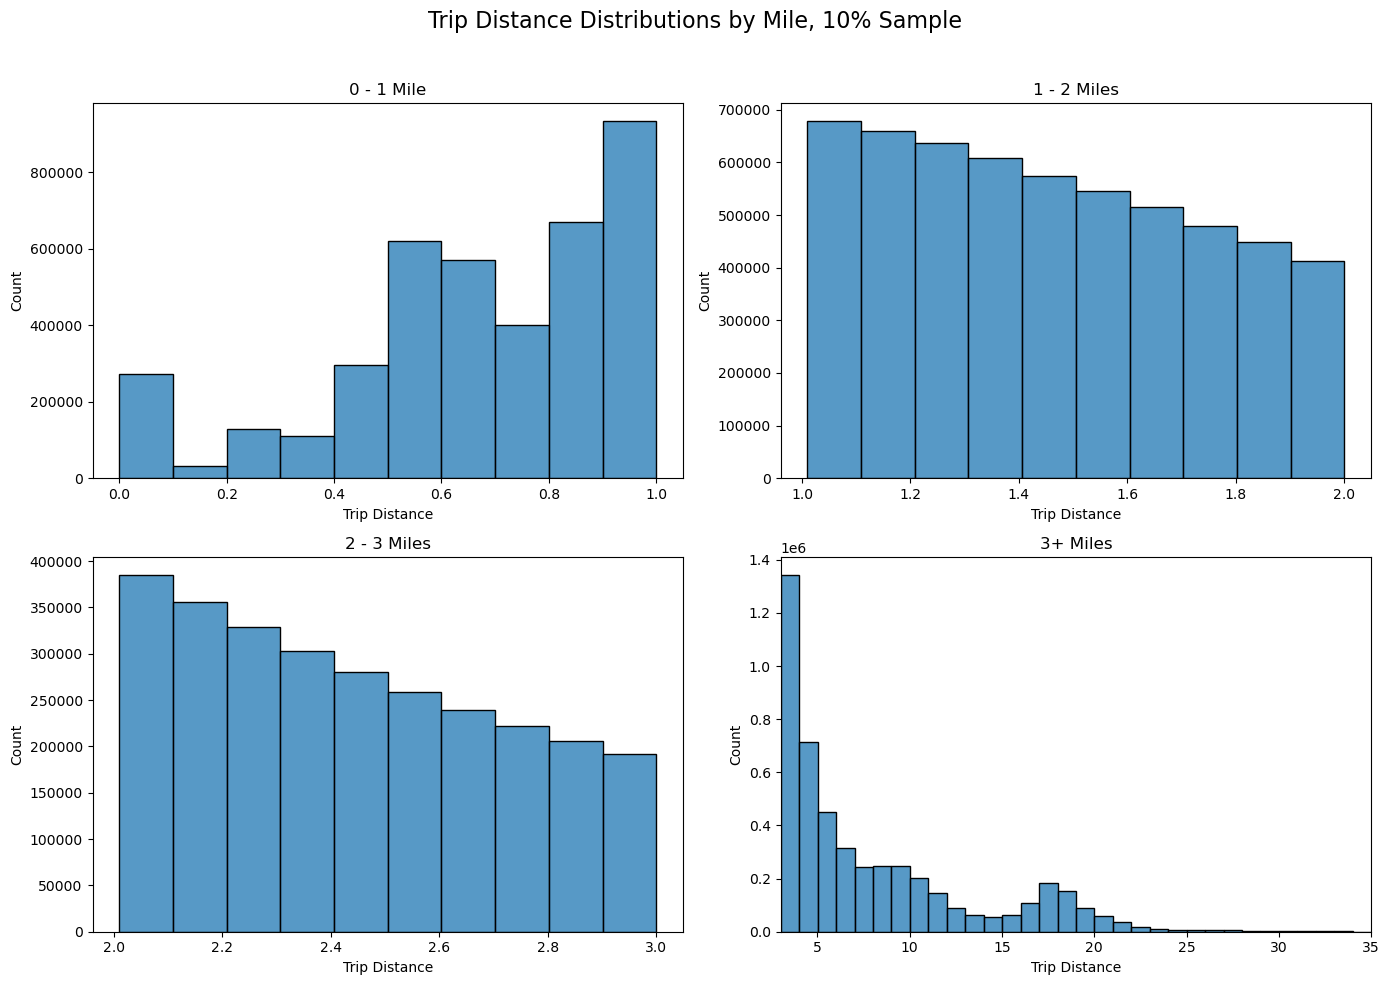

In [16]:
# Filtering sampled data for trip distance ranges
mile_0_1 = df.filter((col("trip_distance") >= 0) & (col("trip_distance") <= 1)) \
             .select("trip_distance").sample(fraction=0.1).toPandas()
mile_1_2 = df.filter((col("trip_distance") > 1) & (col("trip_distance") <= 2)) \
             .select("trip_distance").sample(fraction=0.1).toPandas()
mile_2_3 = df.filter((col("trip_distance") > 2) & (col("trip_distance") <= 3)) \
             .select("trip_distance").sample(fraction=0.1).toPandas()
mile_3_plus = df.filter((col("trip_distance") > 3) & (col("trip_distance") <= 35)) \
                .select("trip_distance").sample(fraction=0.1).toPandas()

# Histogram of Trip Distance by Mile
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Trip Distance Distributions by Mile, 10% Sample", fontsize=16)

# 0–1 mile
sns.histplot(mile_0_1["trip_distance"], bins=10, ax=axes[0, 0])
axes[0, 0].set_title("0 - 1 Mile")
axes[0, 0].set_xlabel("Trip Distance")
axes[0, 0].set_ylabel("Count")

# 1–2 miles
sns.histplot(mile_1_2["trip_distance"], bins=10, ax=axes[0, 1])
axes[0, 1].set_title("1 - 2 Miles")
axes[0, 1].set_xlabel("Trip Distance")
axes[0, 1].set_ylabel("Count")

# 2–3 miles
sns.histplot(mile_2_3["trip_distance"], bins=10, ax=axes[1, 0])
axes[1, 0].set_title("2 - 3 Miles")
axes[1, 0].set_xlabel("Trip Distance")
axes[1, 0].set_ylabel("Count")

# 3+ miles
sns.histplot(mile_3_plus["trip_distance"], bins=32, ax=axes[1, 1])
axes[1, 1].set_title("3+ Miles")
axes[1, 1].set_xlabel("Trip Distance")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_xlim(3, 35)

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

#### Most trips are short distances. The standard rate (ratecode = 1) is for NYC county only. Filtering for trips > 0 and <= 35 miles as the distance of NYC is approx 35 miles. 
- "...the longest distance between its boundaries, from the northeast to the southwest, is about 35 miles."
##### source: https://www.takewalks.com/blog/nyc-by-the-numbers#:~:text=The%20total%20area%20of%20the,Staten%20Island%20and%20Long%20Island.

In [17]:
# Filter Trip Distance
df = df.filter((col("trip_distance") > 0) & (col("trip_distance") <= 35))

### RatecodeID

In [18]:
ratecode_counts = df.groupBy("RatecodeID").count()

metered_row = ratecode_counts.filter(col("RatecodeID") == 1).collect()[0]
metered_count = metered_row["count"]

total_count = ratecode_counts.agg({"count": "sum"}).collect()[0][0]

print(f"Metered fare rides (RatecodeID == 1): {metered_count:,}")
print(f"Percentage of rides (RatecodeID == 1): {metered_count / total_count:.2%}")

Metered fare rides (RatecodeID == 1): 154,694,343
Percentage of rides (RatecodeID == 1): 91.00%


#### Focusing on `RateCodeID = 1`, which represents standard metered fares—these account for approximately 90% of all rides. Other rate codes, such as 2 and 3, correspond to flat fares and negotiated rates.

##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

##### Below are the rate codes and their meaning. 
###### 1= Standard rate
###### 2=JFK (flat rate)
###### 3=Newark (typically flat rate)
###### 4=Nassau or Westchester (flat rate or negotiated)
###### 5=Negotiated fare
###### 6=Group ride

In [19]:
# Filtering to RatecodeID == 1
df = df.filter(col("RatecodeID") == 1)

### Features

In [20]:
# Correlation with fare amount

columns = ["trip_distance",
           "trip_time_minutes",
           "fare_per_min",
           "fare_per_mile",
           "passenger_count",
           "hour",
           "dayofweek",
           "month",
           "payment_type",
           "congestion_surcharge",
           "tolls_amount",
           "PULocationID",
           "DOLocationID",
           "tip_amount",
           "fare_amount"] # Target column for sampling
    
# Sampling 10%
corr_df = df.select(columns).sample(fraction=0.1, seed=2).toPandas()

fare_corr = corr_df.corr(numeric_only=True)["fare_amount"].sort_values(ascending=False)
print("Correlation with fare_amount, 10% Sample:")
print(fare_corr)

Correlation with fare_amount, 10% Sample:
fare_amount             1.000000
trip_distance           0.918651
tip_amount              0.561723
tolls_amount            0.478729
trip_time_minutes       0.181897
month                   0.050890
hour                    0.010169
fare_per_min            0.010137
passenger_count         0.003385
dayofweek              -0.012269
payment_type           -0.012951
PULocationID           -0.094977
fare_per_mile          -0.101090
DOLocationID           -0.105680
congestion_surcharge   -0.290950
Name: fare_amount, dtype: float64


#### `trip_distance`, `tip_amount` and `tolls_amount` all have strong to moderate correlations to fare_amount. 
#### Tip amount will be excluded since it’s only known after the ride concludes and is discretionary. Our goal is to predict the fare amount, not the fare plus tip. 
#### Despite low correlation, `trip_in_minutes` significantly reduces RMSE—by more than half—likely because fares are partially based on ride duration, with riders charged per minute. 
#### "70 cents for every 1/5 of a mile when traveling above 12 miles per hour or per 60 seconds in slow traffic or when the vehicle is stopped"
##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245
#### Feature importance analysis in the test notebook showed `trip_distance`, `tip_amount`, `tolls_amount`, and `hour` as the most impactful predictors.

In [21]:
zero_trip_time_count = df.filter(col("trip_time_minutes") == 0).count()
print(f"Rows with zero trip_time_minutes: {zero_trip_time_count}")

Rows with zero trip_time_minutes: 3070


In [22]:
# Filter extreme outliers for trip_time_minutes and tolls_amount

df = df.filter((col("trip_time_minutes") > 0) & (col("trip_time_minutes") <= 1500))

#### Residual analysis during testing revealed that most trips were under 1,500 minutes, with only a few extreme outliers. This confirms that our preprocessing steps preserved the majority of the data. Shown below:

### Data remaining after processing

In [23]:
original_count = raw_df.count() 
filtered_count = df.count()
percent_remaining = (filtered_count / original_count) * 100

print(f"Original row count: {original_count}")
print(f"Filtered row count: {filtered_count}")
print(f"\nPercentage of data retained: {percent_remaining:.2f}%")

Original row count: 174689444
Filtered row count: 154687944

Percentage of data retained: 88.55%


#### We retained 88.55% of the overall data after preprocessing.

# **Train Model**

### Process and Split Data

In [24]:
# Saving df to parquet file
df.select("trip_distance", "trip_time_minutes", "tolls_amount",  "hour", "fare_amount", "tpep_pickup_datetime") \
  .write.mode("overwrite").parquet("/expanse/lustre/projects/uci150/zmosley/lgb_input_data/")

In [25]:
# Dask cluster 
cluster = LocalCluster(n_workers=15,               
                       threads_per_worker=4,  # 15 × 4 = 60 cores
                       memory_limit="12GB")   # 15 × 12 = 180GB
client = Client(cluster)

In [26]:
# Load saved parquet
ddf = dd.read_parquet("/expanse/lustre/projects/uci150/zmosley/lgb_input_data/")

def add_split(pdf, seed=2):
    rng = np.random.default_rng(seed)
    pdf["split"] = rng.random(len(pdf))
    return pdf

split_df = ddf.map_partitions(add_split)

# Split data 80/20
train_df = split_df[split_df["split"] <= 0.8].drop(columns="split")
test_df = split_df[split_df["split"] > 0.8].drop(columns="split")

features = ["trip_distance", "trip_time_minutes", "tolls_amount",  "hour"]
target = "fare_amount"

train_ = train_df[features + [target, "tpep_pickup_datetime"]]
test_ = test_df[features + [target, "tpep_pickup_datetime"]]

X_train = train_[features]
y_train = train_[target]

X_test = test_[features]
y_test = test_[target]

In [27]:
print("X_train partitions:", X_train.npartitions)
print("y_train partitions:", y_train.npartitions)

print("X_train rows:", X_train.shape[0].compute())
print("y_train rows:", y_train.shape[0].compute())

X_train partitions: 104
y_train partitions: 104
X_train rows: 123711371
y_train rows: 123711371


In [28]:
# Evaluators
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", 
                                     predictionCol="prediction", 
                                     metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="fare_amount", 
                                    predictionCol="prediction", 
                                    metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", 
                                   predictionCol="prediction", 
                                   metricName="r2")

### Linear Regression (Baseline Model)

In [29]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_ml = assembler.transform(df).select("features", target)
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=2)

lr = LinearRegression(featuresCol="features", labelCol="fare_amount")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Linear Regression:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Linear Regression:
RMSE: 4.18
MAE: 2.89
R² Score: 0.8454


### LightGBM Regressor (Final Model)

#### While testing locally and on subsets of the data, LightGBM consistantly had the most accuracy so this is the model we chose for our final model. 

In [30]:
dask_lgb_model = DaskLGBMRegressor(n_estimators=200,
                                   max_depth=15,
                                   learning_rate=0.3,
                                   verbosity=1)

dask_lgb_model.fit(X_train, y_train)

# Predictions
train_pred = X_train.copy()
train_pred["prediction"] = dask_lgb_model.predict(X_train)
train_pred["fare_amount"] = y_train
train_pred["tpep_pickup_datetime"] = train_["tpep_pickup_datetime"]

test_pred = X_test.copy()
test_pred["prediction"] = dask_lgb_model.predict(X_test)
test_pred["fare_amount"] = y_test
test_pred["tpep_pickup_datetime"] = test_["tpep_pickup_datetime"]

# Save results as parquets
train_pred.to_parquet("/expanse/lustre/projects/uci150/zmosley/dask_lgb_train_results", write_index=False, coerce_timestamps="us")
test_pred.to_parquet("/expanse/lustre/projects/uci150/zmosley/dask_lgb_test_results", write_index=False, coerce_timestamps="us")

print("Done Training")

/home/zmosley/.local/lib/python3.11/site-packages/lightgbm/dask.py:549: UserWarning: Parameter n_jobs will be ignored.
  _log_warning(f"Parameter {param_alias} will be ignored.")


Finding random open ports for workers
Done Training


In [31]:
joblib.dump(dask_lgb_model, 'dask_lgb_model.pkl')
print("LightGBM Fare Prediction Model saved")

LightGBM Fare Prediction Model saved


# **Evaluate LightGBM Model**

### Train / Test performance

In [32]:
df_train_spark = spark.read.parquet("/expanse/lustre/projects/uci150/zmosley/dask_lgb_train_results")
df_test_spark  = spark.read.parquet("/expanse/lustre/projects/uci150/zmosley/dask_lgb_test_results")

print("Dask LightGBM Training Performance:")
print(f"  RMSE: {evaluator_rmse.evaluate(df_train_spark):.2f}")
print(f"  MAE:  {evaluator_mae.evaluate(df_train_spark):.2f}")
print(f"  R²:   {evaluator_r2.evaluate(df_train_spark):.4f}")

print("\nDask LightGBM Test Performance:")
print(f"  RMSE: {evaluator_rmse.evaluate(df_test_spark):.2f}")
print(f"  MAE:  {evaluator_mae.evaluate(df_test_spark):.2f}")
print(f"  R²:   {evaluator_r2.evaluate(df_test_spark):.4f}")

Dask LightGBM Training Performance:
  RMSE: 2.66
  MAE:  1.91
  R²:   0.9375

Dask LightGBM Test Performance:
  RMSE: 2.66
  MAE:  1.91
  R²:   0.9374


### Train / Test Performance by Year

In [33]:
# Adds year column back 
df_train_spark = df_train_spark.withColumn("year", year("tpep_pickup_datetime"))
df_test_spark = df_test_spark.withColumn("year", year("tpep_pickup_datetime"))

train_years = [row["year"] for row in df_train_spark.select("year").distinct().collect()]
test_years = [row["year"] for row in df_test_spark.select("year").distinct().collect()]

# Metrics by year
print("Dask LightGBM Training Performance by Year:")
for yr in sorted(train_years):
    subset = df_train_spark.filter(col("year") == yr)
    rmse = evaluator_rmse.evaluate(subset)
    mae = evaluator_mae.evaluate(subset)
    r2 = evaluator_r2.evaluate(subset)
    print(f"  {yr}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")

print("\nDask LightGBM Test Performance by Year:")
for yr in sorted(test_years):
    subset = df_test_spark.filter(col("year") == yr)
    rmse = evaluator_rmse.evaluate(subset)
    mae = evaluator_mae.evaluate(subset)
    r2 = evaluator_r2.evaluate(subset)
    print(f"  {yr}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")

Dask LightGBM Training Performance by Year:
  2020: RMSE=2.04, MAE=1.47, R²=0.9298
  2021: RMSE=2.30, MAE=1.64, R²=0.9213
  2022: RMSE=2.62, MAE=1.92, R²=0.9117
  2023: RMSE=3.19, MAE=2.30, R²=0.9340
  2024: RMSE=2.75, MAE=2.03, R²=0.9508

Dask LightGBM Test Performance by Year:
  2020: RMSE=2.03, MAE=1.47, R²=0.9301
  2021: RMSE=2.30, MAE=1.64, R²=0.9210
  2022: RMSE=2.62, MAE=1.92, R²=0.9116
  2023: RMSE=3.19, MAE=2.30, R²=0.9339
  2024: RMSE=2.75, MAE=2.03, R²=0.9507


### Ground Truth Examples

In [34]:
# Randomly sampled train/test examples
train_sample = train_pred.sample(frac=0.001, random_state=2).reset_index(drop=True).compute()
test_sample = test_pred.sample(frac=0.001, random_state=2).reset_index(drop=True).compute()

train_sample["split"] = "Train"
test_sample["split"] = "Test"

example_preds = pd.concat([train_sample, test_sample])
example_preds = example_preds.round(2)

train_out = example_preds.query("split == 'Train'").sample(5, random_state=1)
test_out = example_preds.query("split == 'Test'").sample(5, random_state=1)

print("Train Examples:")
print(train_out[["trip_distance", "trip_time_minutes", "tolls_amount", "fare_amount", "prediction", "split"]])
print("\nTest Examples:")
print(test_out[["trip_distance", "trip_time_minutes", "tolls_amount", "fare_amount", "prediction", "split"]])

Train Examples:
      trip_distance  trip_time_minutes  tolls_amount  fare_amount  prediction  \
329            2.51               7.37          0.00          9.0       10.49   
669            0.03              10.27          0.00          7.5        8.72   
1750           3.98              24.78          0.00         18.0       20.57   
3909           1.88               6.63          0.00          8.0        8.69   
1692           8.74              15.97          6.55         25.0       28.14   

      split  
329   Train  
669   Train  
1750  Train  
3909  Train  
1692  Train  

Test Examples:
     trip_distance  trip_time_minutes  tolls_amount  fare_amount  prediction  \
485           0.59               2.72          0.00          5.1        4.52   
65            3.64              16.48          0.00         14.0       15.80   
63            1.75               7.77          0.00          8.0        8.82   
310           1.17              17.80          0.00         11.5       14.13 

# **Model Fit**

### LightGBM Model Residuals

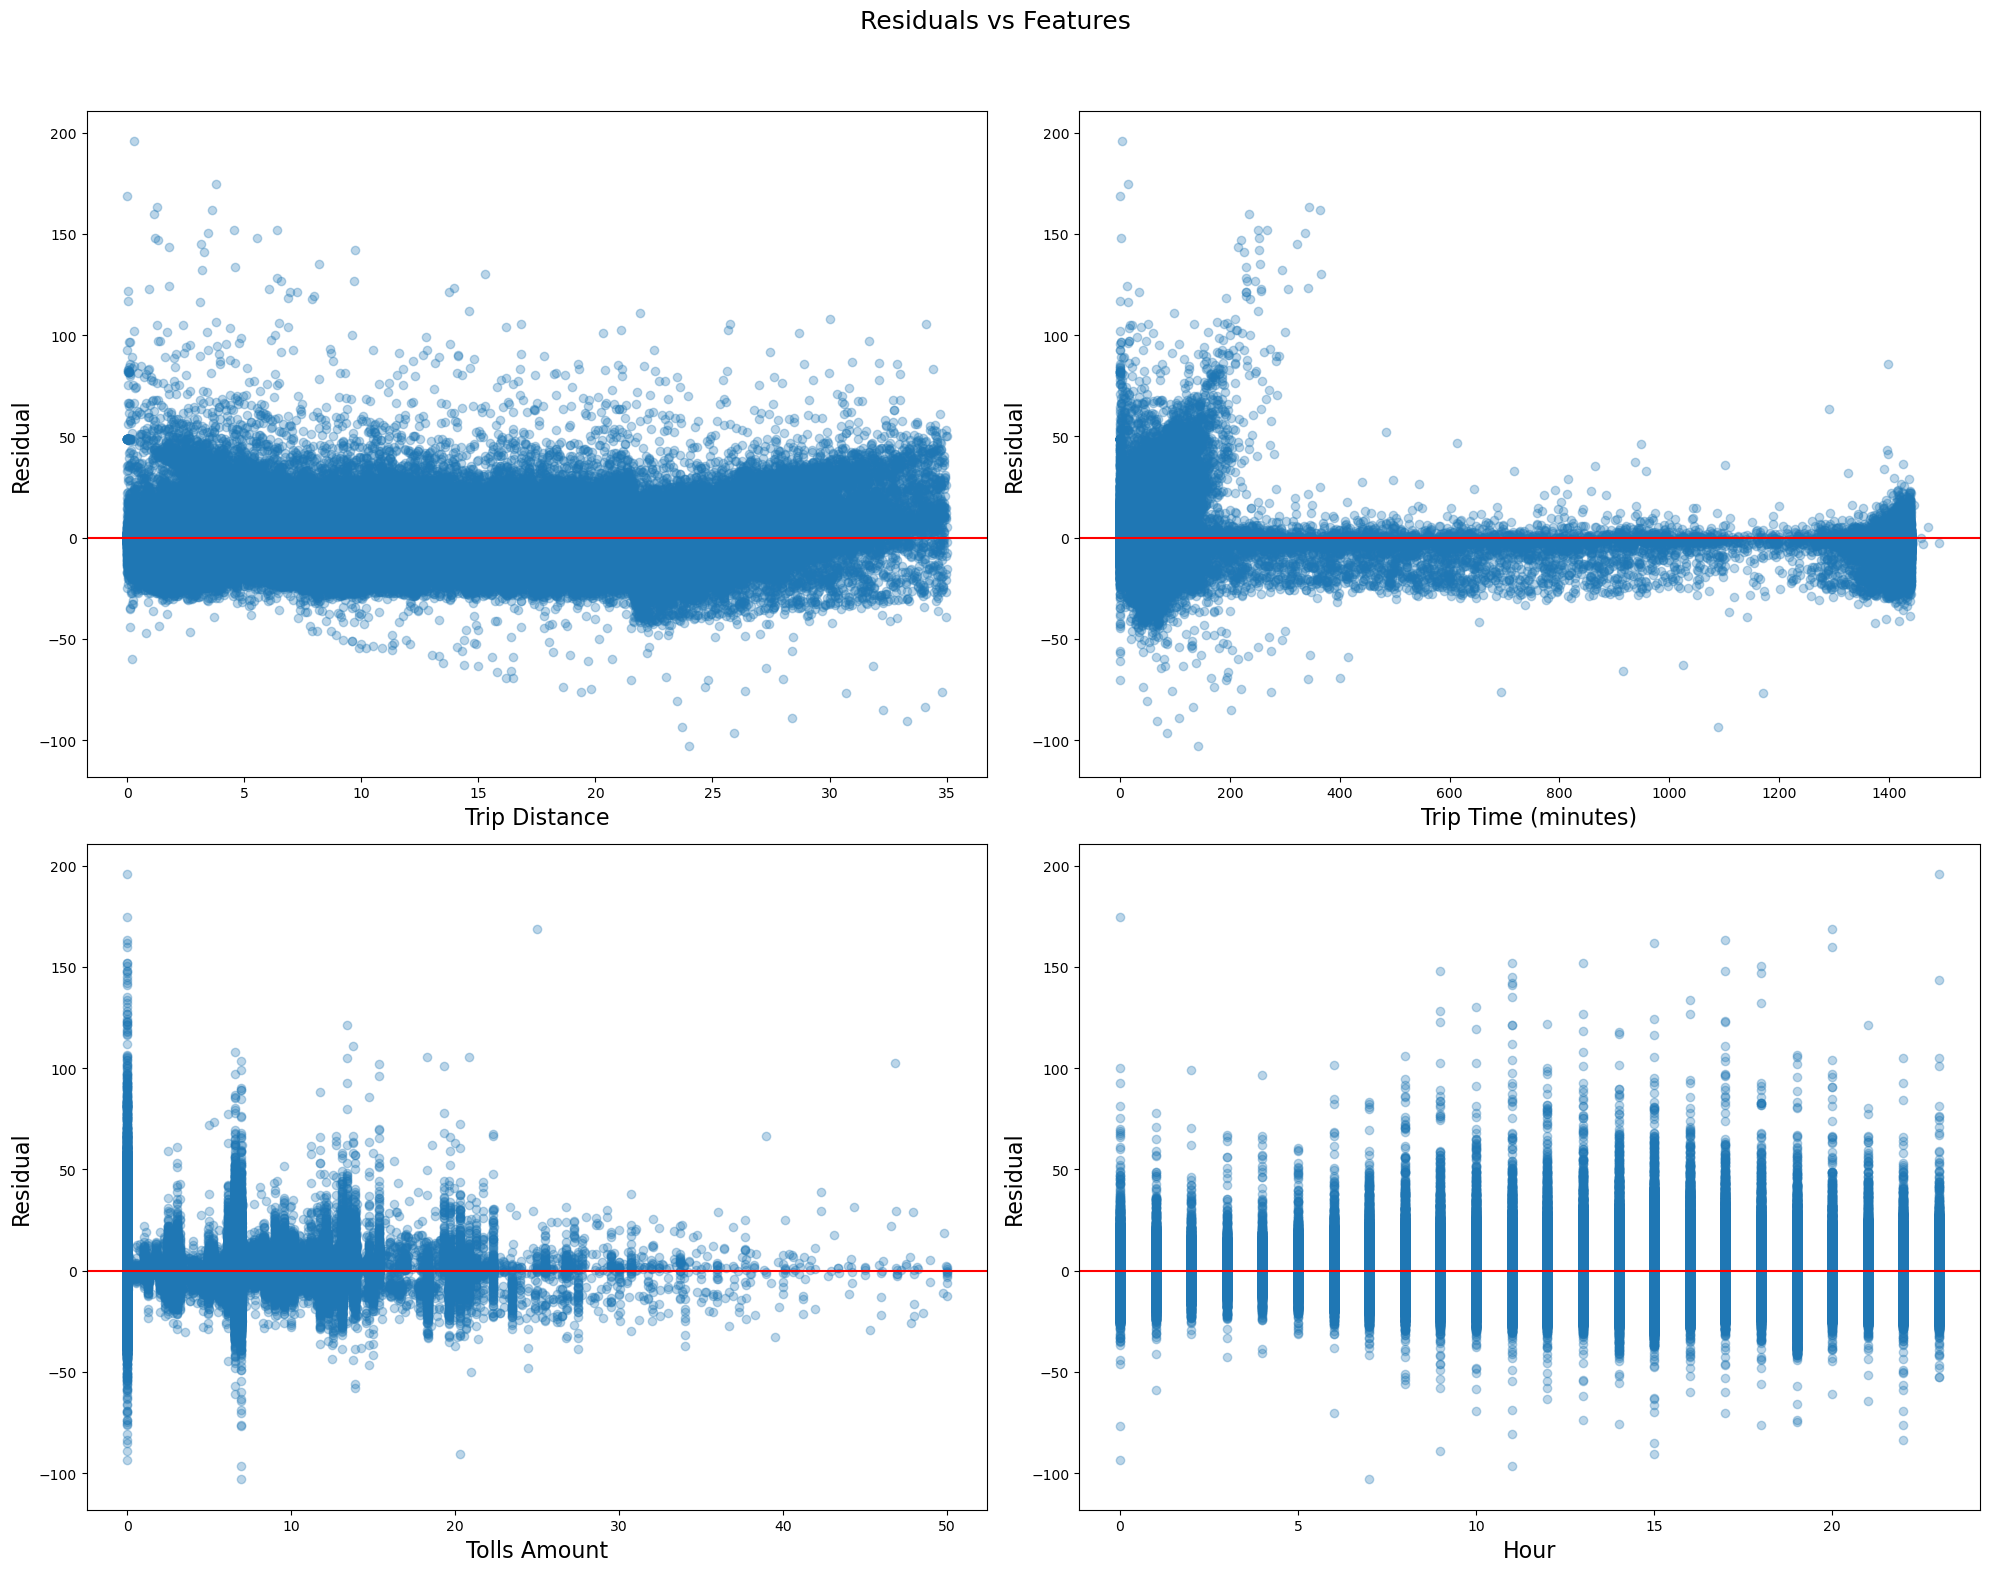

In [35]:
test_pred["residual"] = test_pred["fare_amount"] - test_pred["prediction"]

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle("Residuals vs Features", fontsize=18)

axes[0, 0].scatter(test_pred["trip_distance"], test_pred["residual"], alpha=0.3)
axes[0, 0].axhline(0, color="red")
axes[0, 0].set_xlabel("Trip Distance", fontsize=16)
axes[0, 0].set_ylabel("Residual", fontsize=16)

axes[0, 1].scatter(test_pred["trip_time_minutes"], test_pred["residual"], alpha=0.3)
axes[0, 1].axhline(0, color="red")
axes[0, 1].set_xlabel("Trip Time (minutes)", fontsize=16)
axes[0, 1].set_ylabel("Residual", fontsize=16)

axes[1, 0].scatter(test_pred["tolls_amount"], test_pred["residual"], alpha=0.3)
axes[1, 0].axhline(0, color="red")
axes[1, 0].set_xlabel("Tolls Amount", fontsize=16)
axes[1, 0].set_ylabel("Residual", fontsize=16)

axes[1, 1].scatter(test_pred["hour"], test_pred["residual"], alpha=0.3)
axes[1, 1].axhline(0, color="red")
axes[1, 1].set_xlabel("Hour", fontsize=16)
axes[1, 1].set_ylabel("Residual", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Conclusion

### Summary of Results
Our tuned LightGBM regressor achieved the best performance:

**Test RMSE: `$2.66`**  
**Test MAE: `$1.91`**  
**Test R²: `0.9374`**

With an average fare of `$15.34`, these translate to:

- RMSE ≈ `17.3%` of the mean fare  
- MAE ≈ `12.5%` of the mean fare

This model was trained on NYC Yellow Taxi trip data from 2020 to 2024, and is designed to predict fares during that same period.

This represents a dramatic improvement over our Linear Regression baseline (R²: `0.8454`, RMSE: `$4.18`) and confirms that gradient‐boosted trees capture both linear and nonlinear fare components effectively.

We selected four key features—`trip_time_minutes`, `trip_distance`, `tolls_amount`, and `hour`—as they provided strong predictive power while minimizing overfitting and noise. This feature set supports the model’s ability to generalize well to unseen data.

**Per-Year Model Behavior**  
While overall performance was strong, test metrics varied somewhat across years. The model was most consistent from 2020–2022, with RMSEs between `$2.03–$2.62`, MAEs below `$2.00`, and R² values above `0.91`. However, 2023 showed noticeably higher error (Test RMSE: `$3.19`, MAE: `$2.30`, R²: `0.9339`), suggesting greater volatility or noisier fare dynamics that year—possibly from changing trip patterns, policy shifts, or post-pandemic variability. Performance rebounded in 2024 (Test RMSE: `$2.75`, MAE: `$2.03`, R²: `0.9507`), reinforcing that these anomalies were likely year-specific rather than indicative of model drift.

### Error Analysis
- Low variance: Train and test errors are virtually identical, confirming strong generalization and no overfitting.
- Moderate bias: Systematic underprediction on longer trips and clusters of large residuals at atypical hours or flat-fare services point to remaining nonlinear distance–fare dynamics and surcharge patterns not fully captured by current features.
- Overall error bounds: With MAE ≈ `$1.91`, individual prediction errors stay within reasonable limits, underscoring the model’s reliability.

### Opportunities for Improvement
**Time-Aware Modeling:** Fare structures can shift year to year due to regulatory changes, inflation adjustments, and policy updates. Using fewer recent years or the previous year might better capture current pricing dynamics and improve predictive relevance for upcoming fare estimates.

**External Features:** Incorporate live or historical traffic, weather, or event data to better explain trip time anomalies.

### Final Thoughts
Our tuned LightGBM regressor (Test RMSE: `$2.66`, MAE: `$1.91`, R²: `0.9371`) delivers reliable, production-grade fare estimates. It captures both linear distance-fare trends and nonlinear effects like tolls and surcharges with minimal overfitting. With an RMSE of approximately `±17.3%` and MAE of `±12.5%` relative to the `$15.34` average fare, the model provides a robust, generalizable solution for NYC taxi-fare prediction.

As an additional validation step, we trained a version of the model using only 2019–2023 data and tested it on 2024. Despite never seeing 2024 data during training, it achieved similar performance (RMSE: `2.98`, MAE: `1.88`, R²: `0.9215`). This further supports the model’s ability to generalize to future conditions using its current features and tuning.